In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from IPython.display import display,HTML

from fastai.text.all import *


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# Load and explore the data

In [13]:
path_models = '../'
path = '../data/Twitter Us Airline Sentiment'

In [21]:
df = pd.read_csv('../data/Twitter Us Airline Sentiment/Tweets.csv')

In [22]:
df.shape

(14640, 15)

In [17]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [19]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


<ipython-input-19-c4d51ae7f98d>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-19-c4d51ae7f98d>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
<ipython-input-19-c4d51ae7f98d>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


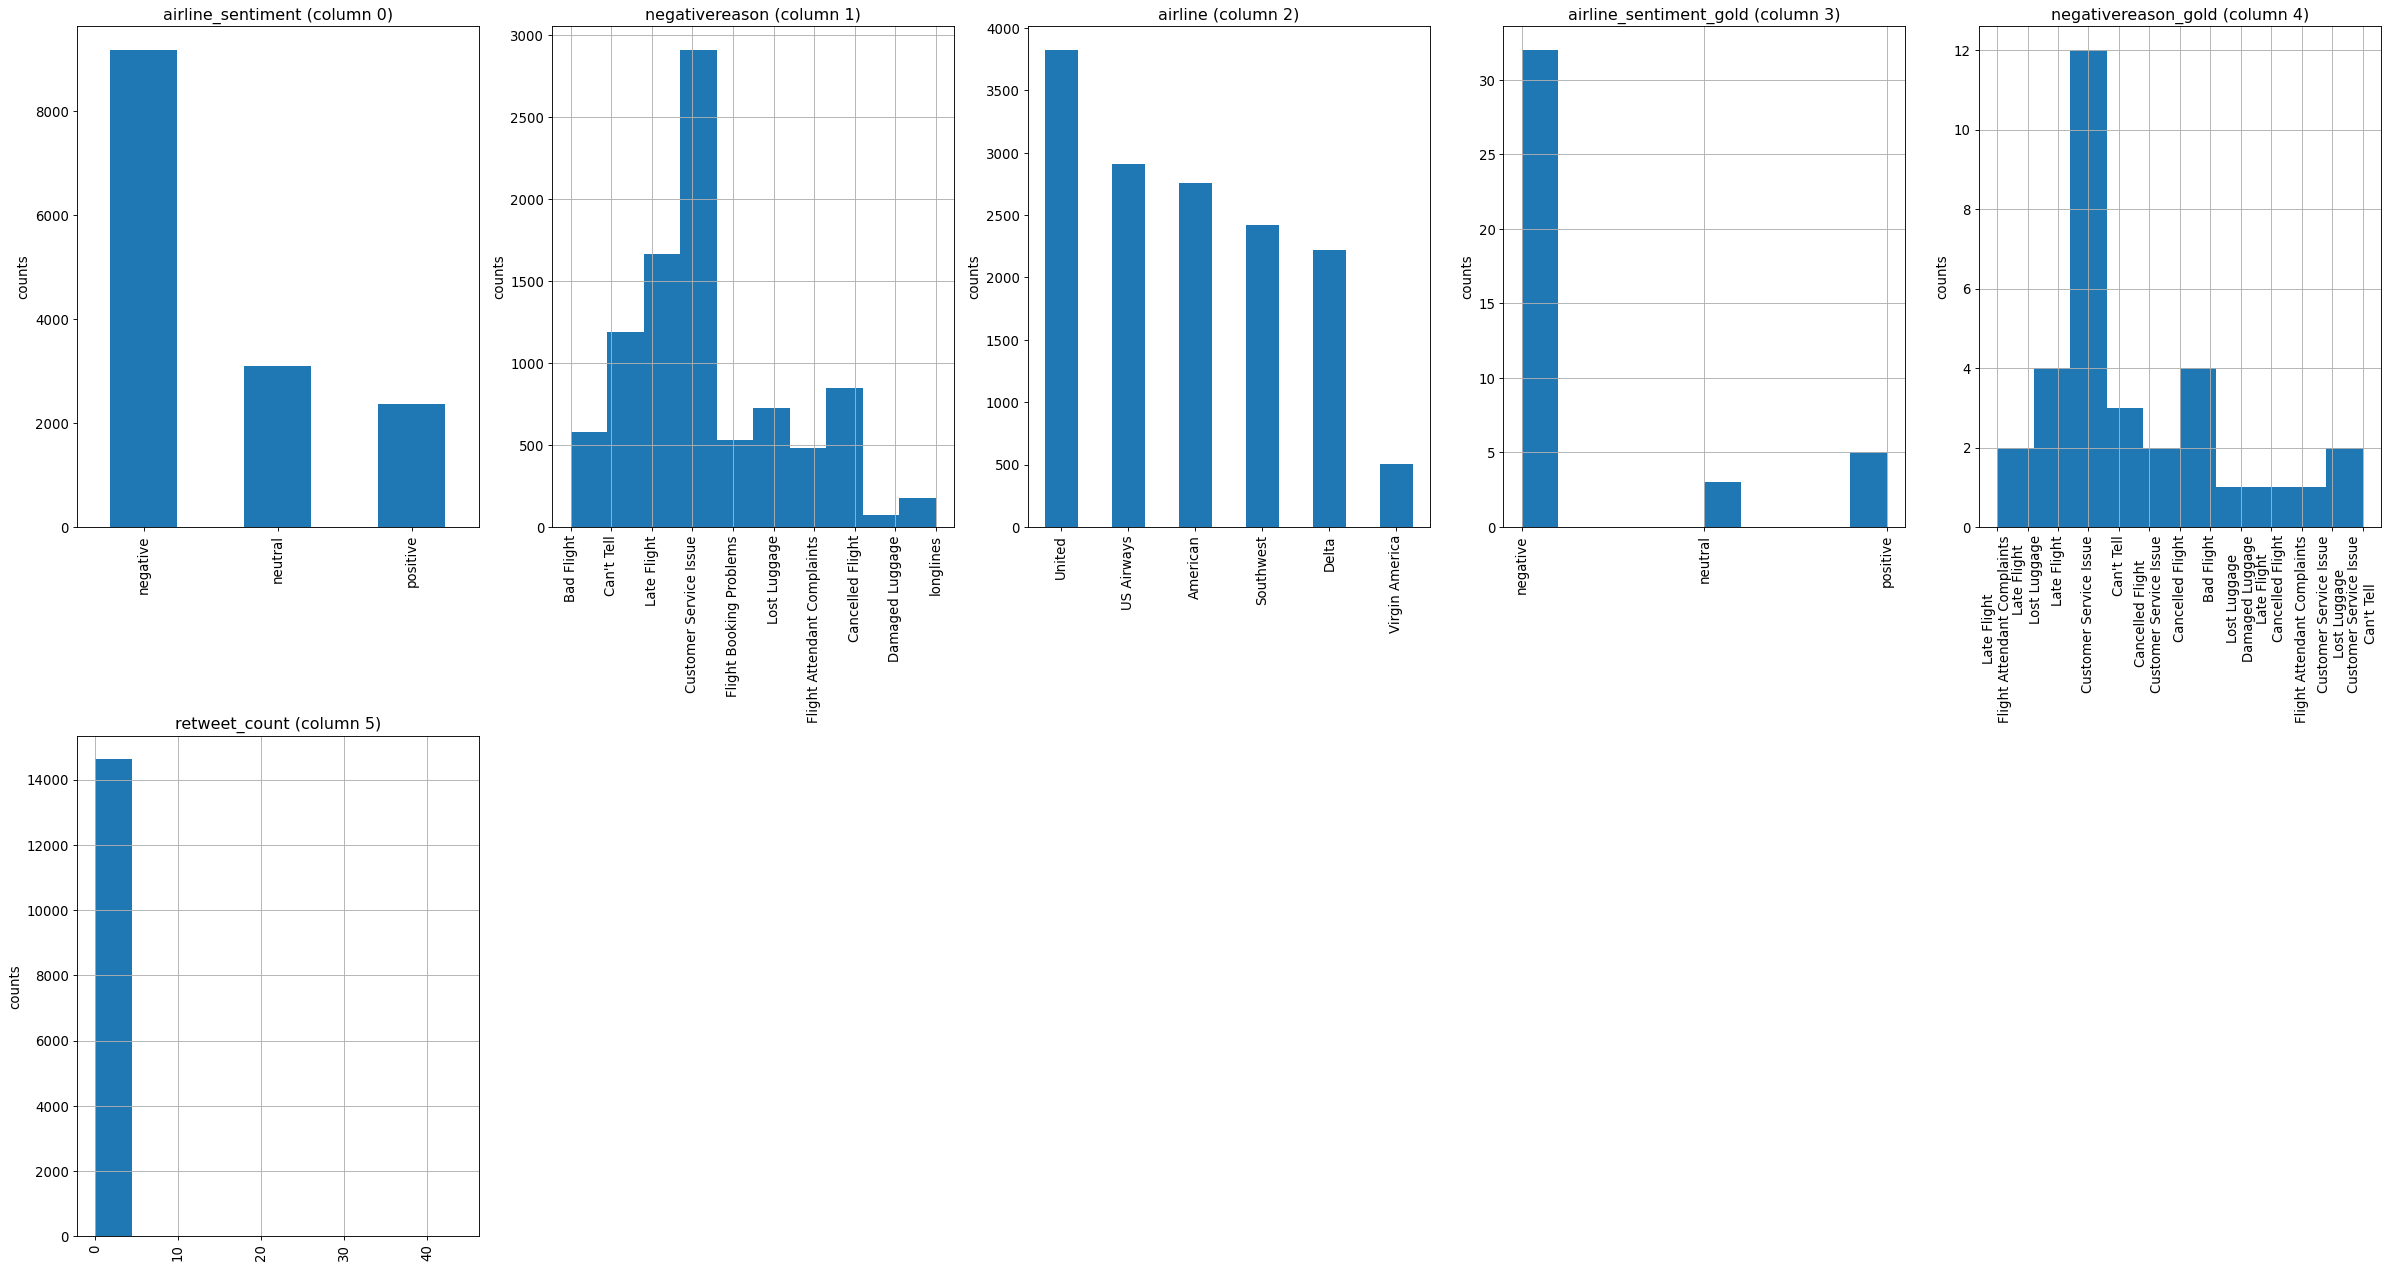

In [20]:
plotPerColumnDistribution(df, 10, 5)

# Training a Text Classifier

In [23]:
dls_lm = TextDataLoaders.from_df(df, path=path_models, text_col='text', is_lm=True)
dls_lm.show_batch(max_n=3)

/home/orjan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,xxbos @united [ checked in + xxunk w / no checkin bagage ] guess i 'm all set . :-) xxbos @usairways thanks for taking my flight off the board xxup and xxup not xxup providing and updates about my flight which is 26 minutes xxmaj late xxmaj flight . xxbos @americanair any idea on what the wait time is for refunds from @usairways ? i was told a few days over,@united [ checked in + xxunk w / no checkin bagage ] guess i 'm all set . :-) xxbos @usairways thanks for taking my flight off the board xxup and xxup not xxup providing and updates about my flight which is 26 minutes xxmaj late xxmaj flight . xxbos @americanair any idea on what the wait time is for refunds from @usairways ? i was told a few days over the
1,looking for something a little more specific . xxbos @usairways is there any way that you could hold flight xxunk in xxup clt my husband is stuck in the security check line . flight scheduled for 1 pm xxbos @jetblue when are you going to get wifi on your planes ? xxbos @southwestair s xxrep 4 h i do n't want something else to steal our deal 😉 xxbos @jetblue xxmaj flight,for something a little more specific . xxbos @usairways is there any way that you could hold flight xxunk in xxup clt my husband is stuck in the security check line . flight scheduled for 1 pm xxbos @jetblue when are you going to get wifi on your planes ? xxbos @southwestair s xxrep 4 h i do n't want something else to steal our deal 😉 xxbos @jetblue xxmaj flight xxmaj
2,xxmaj the flight took off on time . xxbos @united are you telling me that you are now xxmaj cancelled xxmaj flighting my flight ? ? xxbos @usairways will these prices be honored ? xxmaj i ve waited this 1 1 / 2 hours on hold to make sure i can still get the prices i originally started xxbos @usairways xxmaj worst experience ever . xxmaj unable 2 help over phone and,the flight took off on time . xxbos @united are you telling me that you are now xxmaj cancelled xxmaj flighting my flight ? ? xxbos @usairways will these prices be honored ? xxmaj i ve waited this 1 1 / 2 hours on hold to make sure i can still get the prices i originally started xxbos @usairways xxmaj worst experience ever . xxmaj unable 2 help over phone and told


In [30]:
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.02754228748381138)

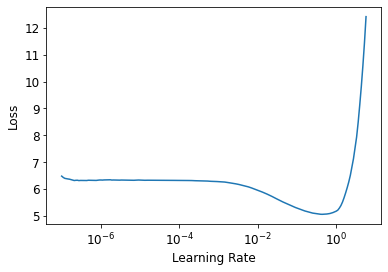

In [31]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [32]:
learn_lm.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.306288,3.964613,0.265647,52.699883,00:09


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

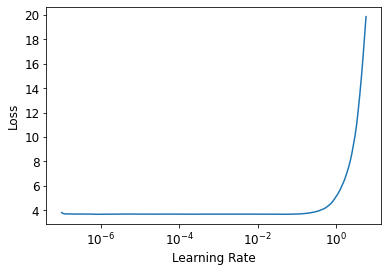

In [33]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [34]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.667680,3.757227,0.288353,42.829483,00:10


SuggestedLRs(lr_min=0.00033113111276179553, lr_steep=2.75422871709452e-06)

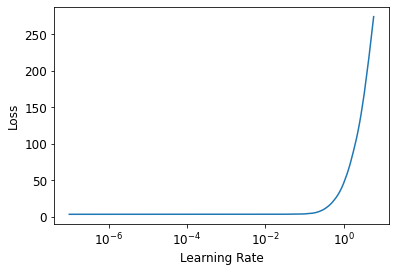

In [35]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [36]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.384539,3.742309,0.294422,42.195320,00:09


In [37]:
learn_lm.save_encoder('02_lm_finetuned')

# Makeing a Tweet

In [38]:
learn_lm = learn_lm.load_encoder('02_lm_finetuned')

In [44]:
TEXT = "cant belive"
N_WORDS = 30
N_SENTENCES = 1
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
print("\n".join(preds))

ca nt xxunk your passengers to get bags from Nashville to Miami even though this is ok @southwestair Using a premium , Virgin America Card and


# Creating a classifier

In [45]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('airline_sentiment'), 
    splitter=RandomSplitter(0.1, seed=(44))
).dataloaders(df, path=path_models)

/home/orjan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [46]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [48]:
learn = learn.load_encoder('02_lm_finetuned')

SuggestedLRs(lr_min=0.47863011360168456, lr_steep=4.365158557891846)

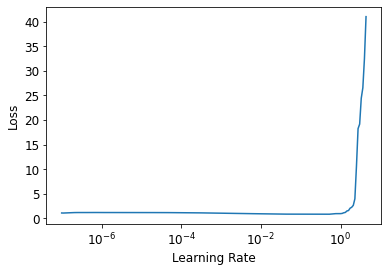

In [49]:
learn.lr_find(stop_div=False, num_it=200)

In [50]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.633876,0.533806,0.783470,00:03


In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.574626,0.498282,0.803962,00:04


In [52]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.503829,0.486671,0.808743,00:05


In [53]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.449061,0.476277,0.816257,00:06
1,0.400630,0.479561,0.814891,00:06


In [54]:
learn.save('02_Classification_model')

Path('../models/02_Classification_model.pth')

In [56]:
learn = learn.load('02_Classification_model')

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

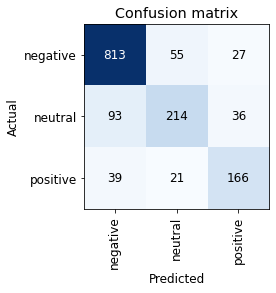

In [58]:
interp.plot_confusion_matrix()

In [59]:
interp.plot_top_losses(5, nrows=1)

,input,target,predicted,probability,loss
0,xxbos @usairways @americanair xxmaj can you bring xxunk xxunk in small pet carrier onboard your flights ?,positive,neutral,0.9455984234809875,7.24343729019165
1,xxbos @united one lady helping the 12 of us with luggage,positive,negative,0.9760589599609375,7.055482387542725
2,xxbos @united thank you !,neutral,positive,0.9946322441101074,6.661632061004639
3,xxbos @americanair thanks !,neutral,positive,0.9946895837783813,6.581496238708496
4,xxbos @united # firstclass to # xxmaj london on my way to # xxunk # xxup xxunk 👠 🇬 🇧 👠 🇬 🇧 👠 🇬 🇧,positive,neutral,0.9963443875312805,5.995849609375
